# OSNAP line Lagrangian particle tracking investigation of the cold/fresh blob


### The aim here is an investigation of the source of the cold/fresh blob which appeared in the near-surface Iceland Basin from about 2014. There are a couple of published explanations for the feature: 

- reduced heat/salt transport across RAPID array and northwards to subpolar N Atlantic over several years (Bryden et al. 2020?) or 
- increased contribution from Labrador Sea water flowing into subpolar North Atlantic rather than southwards (Holliday et al. 2020?). Driven I think by specific,  more intermittent, weather near Flemish Cap (though I need to read this again...)

The technique is to track particles back from the OSNAP line for 4 years and identify those which came from the Gulf Stream and those which came through the Labrador Sea. And see how that changes between from 2006 to 2017. (Elsewhere I have done backwards particle tracking for all years between 2006 and 2017. This supports the results shown here and adds some detail, but 2 years tracking isn't really long enough to identify pathways). I am also trying to quantify the volume/heat/salt transports along each route (not here yet though).

## This notebook plots out the tracks and implements some source tests

## Technical preamble

In [1]:
# import matplotlib.colors as colors
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
import seaborn as sns
# from matplotlib.colors import ListedColormap
import cmocean as co
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import cartopy.crs as ccrs
import cartopy
import seawater as sw
from xhistogram.xarray import histogram


from matplotlib import colors as c
from matplotlib import ticker
# from xhistogram.xarray import histogram

In [2]:
from dask.distributed import Client

In [3]:
client = Client(n_workers=1, threads_per_worker=8, memory_limit=32e9)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/workshop007/proxy/8787/status,
Dashboard: /user/workshop007/proxy/8787/status,Workers: 1
Total threads: 8,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36623,Workers: 1
Dashboard: /user/workshop007/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://134.245.214.97:39683,Total threads: 8
Dashboard: /user/workshop007/proxy/44549/status,Memory: 29.80 GiB
Nanny: tcp://127.0.0.1:45757,


In [4]:
sns.set(style="whitegrid")

xr.set_options(keep_attrs=True)
np.warnings.filterwarnings('ignore')

sns.set_palette("colorblind")
xr.set_options(keep_attrs=True);

plt.rc('font', size=14) #controls default text size
plt.rc('axes', titlesize=14) #fontsize of the title
plt.rc('axes', labelsize=14) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend
plt.rc('savefig', dpi=300)       # higher res outputs

## Set up paths and read in trajectory data

In [5]:
# parameters
project_path = Path.cwd() / '..' / '..' 
project_path = project_path.resolve()

# full datasets
# interim_data_path = Path('/data/spg_fresh_blob_202104_data/interim/')

# 10 percent datasets
interim_data_path = project_path / 'data' / 'interim' / 'endtracks' / 'plusDist' 

outputPath = Path('data/interim/transitTimes/')
output_data_path = project_path / outputPath

sectionPath = Path('data/external/')
sectionFilename = 'osnap_pos_wp.txt'
sectionname = 'osnap'

figure_path = Path('reports/figures/transitTimes/')

year = 2000
nsubsets = 32


In [6]:
yearstr = str(year)

In [7]:

# model mask file
data_path = Path("data/external/iAtlantic/")
experiment_name = "VIKING20X.L46-KKG36107B"
mesh_mask_file =  project_path / data_path / "mask" / experiment_name / "1_mesh_mask.nc"

#section lonlat file
sectionPath = Path('data/external/')
sectionFilename = 'osnap_pos_wp.txt'
sectionname = 'osnap'
gsrsectionFilename = 'gsr_pos_wp.txt'

degree2km = 1.852*60.0

# some transport values specific to osnap runs
# randomly seeded 39995 particles, 19886 were in ocean points (the rest were land)

osnap_section_length = 3594572.87839    # m
osnap_subsection_length = 2375914.29783   # m
osnap_section_depth = 4000 # m over which particles launched
osnap_subsection_depth = 1000 # m over which particles launched

osnap_subsection_ocean_area = osnap_subsection_length * osnap_subsection_depth * 2100000 / 2643886


max_current = 2.0

particle_section_area = max_current * osnap_subsection_length * osnap_subsection_depth / (2643886)

## Load data

### mesh and masks

In [8]:
mesh_mask = xr.open_dataset(mesh_mask_file)
mesh_mask = mesh_mask.squeeze()
mesh_mask = mesh_mask.set_coords(["nav_lon", "nav_lat", "nav_lev"])

bathy = mesh_mask.mbathy.rename("number of water filled points")

depth = (mesh_mask.e3t_0 * mesh_mask.tmask).sum("z")
# display(mesh_mask)

### section position data

In [9]:
lonlat = xr.Dataset(pd.read_csv(project_path / sectionPath / sectionFilename,delim_whitespace=True))

In [10]:
lonlat.lon.attrs['long_name']='Longitude'
lonlat.lat.attrs['long_name']='Latitude'
lonlat.lon.attrs['standard_name']='longitude'
lonlat.lat.attrs['standard_name']='latitude'
lonlat.lon.attrs['units']='degrees_east'
lonlat.lat.attrs['units']='degrees_north'

lonlat2mean= lonlat.rolling({'dim_0':2}).mean()

lonlatdiff = (lonlat.diff('dim_0'))

lonlatdiff = lonlatdiff.assign({'y':lonlatdiff['lat']*degree2km})
lonlatdiff = lonlatdiff.assign({'x':lonlatdiff['lon']*degree2km*np.cos(np.radians(lonlat2mean.lat.data[1:]))})
lonlatdiff=lonlatdiff.assign({'length':np.sqrt(lonlatdiff['x']**2+lonlatdiff['y']**2)})
lonlatdiff=lonlatdiff.assign({'costheta':lonlatdiff['x']/lonlatdiff['length']})
lonlatdiff=lonlatdiff.assign({'sintheta':lonlatdiff['y']/lonlatdiff['length']})

total_length = lonlatdiff.length.sum().data 
total_osnap_length = lonlatdiff.length[0:12].sum().data;  # exclude section across UK - just there for testing north/south

length_west = xr.concat((xr.DataArray([0],dims=("dim_0"),coords={"dim_0": [0]}),lonlatdiff.length.cumsum()),dim='dim_0')

In [11]:
lonlat

<xarray.Dataset>
Dimensions:  (dim_0: 13)
Coordinates:
  * dim_0    (dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    lat      (dim_0) float64 52.09 52.67 53.59 59.11 ... 57.99 57.47 57.1 56.73
    lon      (dim_0) float64 -56.16 -52.1 -49.78 -47.34 ... -12.71 -9.275 -5.77

## Load endtrack data

We'll first find all the relevant files and then open them as a virtual contiguous dataset.

In [12]:
# data_stores_subsets = list(sorted(Path(data_path).glob("*_????_subset.zarr/")))[:use_number_subset_years]
data_trackends_subsets = list(sorted(Path(interim_data_path).glob(f"*.nc/")))


In [13]:
print(data_trackends_subsets)

[PosixPath('/home/jupyter-workshop007/Projects/spg_fresh_blob_202104/data/interim/endtracks/plusDist/endtracks_20211215_randomvel_mxl_osnap_backwards_1990_subset_10percent.nc'), PosixPath('/home/jupyter-workshop007/Projects/spg_fresh_blob_202104/data/interim/endtracks/plusDist/endtracks_20211215_randomvel_mxl_osnap_backwards_1991_subset_10percent.nc'), PosixPath('/home/jupyter-workshop007/Projects/spg_fresh_blob_202104/data/interim/endtracks/plusDist/endtracks_20211215_randomvel_mxl_osnap_backwards_1992_subset_10percent.nc'), PosixPath('/home/jupyter-workshop007/Projects/spg_fresh_blob_202104/data/interim/endtracks/plusDist/endtracks_20211215_randomvel_mxl_osnap_backwards_1993_subset_10percent.nc'), PosixPath('/home/jupyter-workshop007/Projects/spg_fresh_blob_202104/data/interim/endtracks/plusDist/endtracks_20211215_randomvel_mxl_osnap_backwards_1994_subset_10percent.nc'), PosixPath('/home/jupyter-workshop007/Projects/spg_fresh_blob_202104/data/interim/endtracks/plusDist/endtracks_2021

In [14]:
ds = xr.concat(
    [xr.open_dataset(store,chunks={
        "ends": 2, "traj": 1048576
    }) for store in data_trackends_subsets[0:None]],
    dim="traj",
)
# ds = xr.concat(
#     [xr.open_dataset(store) for store in data_trackends_subsets],
#     dim="traj",
# )

display(ds)
print(ds.nbytes / 1e9, "GiB")

<xarray.Dataset>
Dimensions:          (ends: 2, traj: 14143053)
Dimensions without coordinates: ends, traj
Data variables: (12/19)
    lat              (ends, traj) float32 dask.array<chunksize=(2, 516415), meta=np.ndarray>
    lon              (ends, traj) float32 dask.array<chunksize=(2, 516415), meta=np.ndarray>
    mxl              (ends, traj) float32 dask.array<chunksize=(2, 516415), meta=np.ndarray>
    salt             (ends, traj) float32 dask.array<chunksize=(2, 516415), meta=np.ndarray>
    temp             (ends, traj) float32 dask.array<chunksize=(2, 516415), meta=np.ndarray>
    time             (ends, traj) datetime64[ns] dask.array<chunksize=(2, 516415), meta=np.ndarray>
    ...               ...
    GulfS_is_source  (ends, traj) bool dask.array<chunksize=(2, 516415), meta=np.ndarray>
    other_is_source  (ends, traj) bool dask.array<chunksize=(2, 516415), meta=np.ndarray>
    Green_is_source  (ends, traj) bool dask.array<chunksize=(2, 516415), meta=np.ndarray>
    Davis_is_source  (ends, traj) bool dask.array<chunksize=(2, 516415), meta=np.ndarray>
    Hudba_is_source  (ends, traj) bool dask.array<chunksize=(2, 516415), meta=np.ndarray>
    north_of_osnap   (ends, traj) bool dask.array<chunksize=(2, 516415), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

1.499163618 GiB


#### Subset tracks by OSNAP line cross longitude and depth range

In [15]:
lonRange=[-37,0]
depthRange=[0,1000]
range_str = 'OsnapE_37W_0_500m'

In [16]:
ds = ds.where((ds.isel(ends=0).lon > lonRange[0]) & (ds.isel(ends=0).lon < lonRange[1]))
ds = ds.where((ds.isel(ends=0).z > depthRange[0]) & (ds.isel(ends=0).z < depthRange[1]))
ds = ds.where(ds.isel(ends=0).north_of_osnap == False)
ds = ds.dropna('traj', how='all')
    

In [17]:
deltaT = -1*ds.time.diff(dim='ends').squeeze()
ds["deltaT"]=deltaT

In [18]:
ds=ds.compute()

In [19]:
ds.isel(ends=0).other_is_source.sum().compute()

<xarray.DataArray 'other_is_source' ()>
array(745912.)
Attributes:
    long_name:  flag source not found

#### Add density (sigma0) to variables

In [20]:
ds = ds.assign({'rho0':xr.apply_ufunc(
    sw.dens,
    ds.salt,ds.temp,0,
    dask="parallelized",
    output_dtypes=[float, ])})
ds.rho0.attrs = {'units':'kg/m3','long_name':'potential density $\rho_0$'}

#### Velocity conversions from degrees lat/lon per second to m/s

In [21]:
ds=ds.assign({'uvel_ms':ds.uvel * degree2km * 1000.0 * np.cos(np.radians(ds.lat))})
ds=ds.assign({'vvel_ms':ds.vvel * degree2km * 1000.0})

In [22]:
ds = ds.assign({'section_index':(ds.isel(ends=0).lon > lonlat.lon).sum(dim='dim_0')-1})

In [23]:
costheta = lonlatdiff.costheta[ds.section_index]
sintheta = lonlatdiff.sintheta[ds.section_index]

In [24]:
ds = ds.assign({'u_normal':ds.isel(ends=0).vvel_ms * costheta - 
                           ds.isel(ends=0).uvel_ms * sintheta})
ds = ds.assign({'u_along':ds.isel(ends=0).vvel_ms * sintheta + 
                          ds.isel(ends=0).uvel_ms * costheta})

#### Find along-section distances of initial points

In [25]:
ds = ds.assign({'x':xr.DataArray(length_west[ds.section_index] + lonlatdiff.length[ds.section_index]*
                              (ds.isel(ends=0).lon - lonlat.lon[ds.section_index])/lonlatdiff.lon[ds.section_index],dims='traj')})

### volume, temperature and salt transports along track

In [26]:
# at osnap line
ds = ds.assign({'vol_trans_normal':np.sign(ds.u_normal) * particle_section_area/1.0e06})
ds = ds.assign({'particle_vol':ds.vol_trans_normal/ds.u_normal})

In [27]:
# at osnap line
ds = ds.assign({'temp_transport':ds.temp * ds.vol_trans_normal})
ds = ds.assign({'salt_transport':ds.salt * ds.vol_trans_normal})
ds = ds.assign({'depth_transport':ds.z * ds.vol_trans_normal})
ds = ds.assign({'lon_transport':ds.lon * ds.vol_trans_normal})
ds = ds.assign({'tempxvol':ds.temp * ds.particle_vol})
ds = ds.assign({'saltxvol':ds.salt * ds.particle_vol})
ds = ds.assign({'depthxvol':ds.z * ds.particle_vol})
ds = ds.assign({'lonxvol':ds.lon * ds.particle_vol})


In [28]:
ds

<xarray.Dataset>
Dimensions:           (ends: 2, traj: 3838344)
Coordinates:
    dim_0             (traj) int64 6 6 6 6 6 6 6 6 6 ... 12 12 12 12 12 12 12 12
Dimensions without coordinates: ends, traj
Data variables: (12/37)
    lat               (ends, traj) float32 59.15 59.01 59.04 ... 44.11 36.19
    lon               (ends, traj) float32 -33.92 -32.55 ... -13.87 -14.91
    mxl               (ends, traj) float32 214.9 338.1 337.1 ... 122.3 78.34
    salt              (ends, traj) float32 34.93 35.12 35.1 ... 35.61 35.64
    temp              (ends, traj) float32 3.812 7.324 6.744 ... 14.07 12.66
    time              (ends, traj) datetime64[ns] 1990-01-03T12:00:00 ... 200...
    ...                ...
    depth_transport   (ends, traj) float64 1.068 0.3546 0.801 ... 0.1644 0.5197
    lon_transport     (ends, traj) float64 -0.06097 -0.0585 ... -0.02493 -0.0268
    tempxvol          (ends, traj) float64 0.0804 0.2458 ... 0.1951 0.1954
    saltxvol          (ends, traj) float64 0.7368 1.179 2.112 ... 0.4936 0.5501
    depthxvol         (ends, traj) float64 12.53 6.62 26.81 ... 1.268 4.464
    lonxvol           (ends, traj) float64 -0.7156 -1.092 ... -0.1923 -0.2301
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

In [29]:
ds = ds.where(ds.isel(ends=0).u_normal >= 0.0)
ds = ds.dropna('traj', how='all')

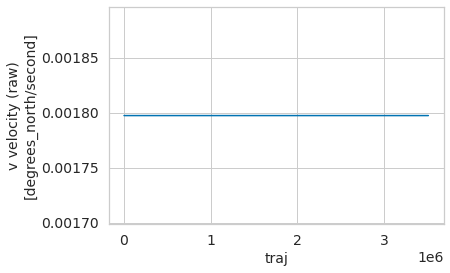

In [30]:
ds.vol_trans_normal.plot()

In [31]:
osnap_time = ds.time.isel(ends=0)

In [32]:
osnap_time

<xarray.DataArray 'time' (traj: 3513397)>
array(['1990-01-03T12:00:00.000000000', '1990-01-03T12:00:00.000000000',
       '1990-01-03T12:00:00.000000000', ...,
       '2019-12-29T12:00:00.000000000', '2019-12-29T12:00:00.000000000',
       '2019-12-29T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    dim_0    (traj) int64 6 6 6 6 6 6 6 6 6 6 ... 12 12 12 12 12 12 12 12 12 12
Dimensions without coordinates: traj
Attributes:
    axis:           T
    long_name:      
    standard_name:  time

In [33]:
dist = ds.dist.isel(ends=1).where(ds.isel(ends=0).other_is_source == False)
deltaT = ds.deltaT.astype(int).where(ds.isel(ends=0).other_is_source == False)
lon = ds.lon.isel(ends=0).where(ds.isel(ends=0).other_is_source == False)
nls = ds.isel(ends=0).LabCu_is_source
ngs = ds.isel(ends=0).GulfS_is_source
nos = ds.isel(ends=0).other_is_source
nld = ds.isel(ends=0).LCdir_is_path
nll = ds.isel(ends=0).LC60W_is_path

dist_ls = dist.where(ds.isel(ends=0).LabCu_is_source)
deltaT_ls = deltaT.where(ds.isel(ends=0).LabCu_is_source)
lon_ls = lon.where(ds.isel(ends=0).LabCu_is_source)

dist_gs = dist.where(ds.isel(ends=0).GulfS_is_source)
deltaT_gs = deltaT.where(ds.isel(ends=0).GulfS_is_source)
lon_gs = lon.where(ds.isel(ends=0).GulfS_is_source)

dist_ld = dist.where(ds.isel(ends=0).LCdir_is_path)
deltaT_ld = deltaT.where(ds.isel(ends=0).LCdir_is_path)
lon_ld = lon.where(ds.isel(ends=0).LCdir_is_path)

dist_ll = dist.where(ds.isel(ends=0).LC60W_is_path)
deltaT_ll = deltaT.where(ds.isel(ends=0).LC60W_is_path)
lon_ll = lon.where(ds.isel(ends=0).LC60W_is_path)


In [34]:
dist_5day = dist.groupby(osnap_time).mean().compute()
deltaT_5day = deltaT.groupby(osnap_time).mean().compute()
lon_5day = lon.groupby(osnap_time).mean().compute()
nls_5day = nls.groupby(osnap_time).sum().compute()
ngs_5day = ngs.groupby(osnap_time).sum().compute()
nos_5day = nos.groupby(osnap_time).sum().compute()
nld_5day = nld.groupby(osnap_time).sum().compute()
nll_5day = nll.groupby(osnap_time).sum().compute()

dist_5day_ls = dist_ls.groupby(osnap_time).mean().compute()
deltaT_5day_ls = deltaT_ls.groupby(osnap_time).mean().compute()
lon_5day_ls = lon_ls.groupby(osnap_time).mean().compute()

dist_5day_gs = dist_gs.groupby(osnap_time).mean().compute()
deltaT_5day_gs = deltaT_gs.groupby(osnap_time).mean().compute()
lon_5day_gs = lon_gs.groupby(osnap_time).mean().compute()

dist_5day_ld = dist_ld.groupby(osnap_time).mean().compute()
deltaT_5day_ld = deltaT_ld.groupby(osnap_time).mean().compute()
lon_5day_ld = lon_ld.groupby(osnap_time).mean().compute()

dist_5day_ll = dist_ll.groupby(osnap_time).mean().compute()
deltaT_5day_ll = deltaT_ll.groupby(osnap_time).mean().compute()
lon_5day_ll = lon_ll.groupby(osnap_time).mean().compute()


In [35]:
dist_5day

<xarray.DataArray 'dist' (time: 2189)>
array([16533173., 16671340., 16840714., ..., 15262093., 14710652.,
       14840645.], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-03T12:00:00 ... 2019-12-29T12:00:00
Attributes:
    long_name:  alongtrack distance from OSNAP
    units:      metres

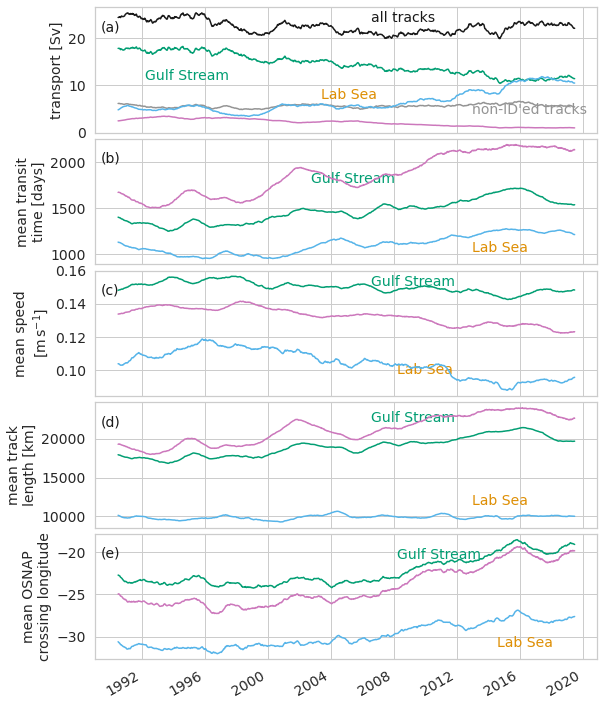

In [36]:
fig,ax = plt.subplots(5,figsize = (9,12),sharex=True,gridspec_kw={'hspace':0.05})

# (dist_5day/1000).plot(ax=ax[0],color='C0',alpha=0.5,zorder=5)
# (deltaT_5day/(1.0e9*24*3600)).plot(ax=ax[1],color='C0',alpha=0.5,zorder=5)
# (dist_5day/(deltaT_5day.astype(int)/1.0e09)).plot(ax=ax[2],color='C0',alpha=0.5,zorder=5)
# (lon_5day).plot(ax=ax[3],color='C0',alpha=0.5,zorder=5)
# (dist_5day/1000).rolling(time=73,center=True).mean().plot(ax=ax[3],color='C0',zorder=10)
# (deltaT_5day/(1.0e9*24*3600)).rolling(time=73,center=True).mean().plot(ax=ax[1],color='C0',zorder=10)
# (dist_5day/(deltaT_5day.astype(int)/1.0e09)).rolling(time=73,center=True).mean().plot(ax=ax[2],color='C0',zorder=10)
# (lon_5day).rolling(time=73,center=True).mean().plot(ax=ax[4],color='C0',zorder=10)

# (dist_5day_ls/1000).plot(ax=ax[0],color='C1',alpha=0.5,zorder=4)
# (deltaT_5day_ls/(1.0e9*24*3600)).plot(ax=ax[1],color='C1',alpha=0.5,zorder=4)
# (dist_5day_ls/(deltaT_5day_ls.astype(int)/1.0e09)).plot(ax=ax[2],color='C1',alpha=0.5,zorder=4)
# (lon_5day_ls).plot(ax=ax[3],color='C1',alpha=0.5,zorder=4)
# (dist_5day_ls/1000).rolling(time=73,center=True).mean().plot(ax=ax[3],color='C1',zorder=9)
# (deltaT_5day_ls/(1.0e9*24*3600)).rolling(time=73,center=True).mean().plot(ax=ax[1],color='C1',zorder=9)
# (dist_5day_ls/(deltaT_5day_ls.astype(int)/1.0e09)).rolling(time=73,center=True).mean().plot(ax=ax[2],color='C1',zorder=9)
# (lon_5day_ls).rolling(time=73,center=True).mean().plot(ax=ax[4],color='C1',zorder=9)

# (dist_5day_gs/1000).plot(ax=ax[0],color='C2',alpha=0.5,zorder=3)
# (deltaT_5day_gs/(1.0e9*24*3600)).plot(ax=ax[1],color='C2',alpha=0.5,zorder=3)
# (dist_5day_gs/(deltaT_5day_gs.astype(int)/1.0e09)).plot(ax=ax[2],color='C2',alpha=0.5,zorder=3)
# (lon_5day_gs).plot(ax=ax[3],color='C2',alpha=0.5,zorder=3)
(dist_5day_gs/1000).rolling(time=73,center=True).mean().plot(ax=ax[3],color='C2',zorder=8)
(deltaT_5day_gs/(1.0e9*24*3600)).rolling(time=73,center=True).mean().plot(ax=ax[1],color='C2',zorder=8)
(dist_5day_gs/(deltaT_5day_gs.astype(int)/1.0e09)).rolling(time=73,center=True).mean().plot(ax=ax[2],color='C2',zorder=8)
(lon_5day_gs).rolling(time=73,center=True).mean().plot(ax=ax[4],color='C2',zorder=8)

(dist_5day_ld/1000).rolling(time=73,center=True).mean().plot(ax=ax[3],color='C9',zorder=9)
(deltaT_5day_ld/(1.0e9*24*3600)).rolling(time=73,center=True).mean().plot(ax=ax[1],color='C9',zorder=9)
(dist_5day_ld/(deltaT_5day_ld.astype(int)/1.0e09)).rolling(time=73,center=True).mean().plot(ax=ax[2],color='C9',zorder=9)
(lon_5day_ld).rolling(time=73,center=True).mean().plot(ax=ax[4],color='C9',zorder=9)

(dist_5day_ll/1000).rolling(time=73,center=True).mean().plot(ax=ax[3],color='C4',zorder=9)
(deltaT_5day_ll/(1.0e9*24*3600)).rolling(time=73,center=True).mean().plot(ax=ax[1],color='C4',zorder=9)
(dist_5day_ll/(deltaT_5day_ll.astype(int)/1.0e09)).rolling(time=73,center=True).mean().plot(ax=ax[2],color='C4',zorder=9)
(lon_5day_ll).rolling(time=73,center=True).mean().plot(ax=ax[4],color='C4',zorder=9)


# (ngs_5day+nls_5day).plot(ax=ax[4],color='C0',alpha=0.5,zorder=5)
# nls_5day.plot(ax=ax[4],color='C1',alpha=0.5,zorder=4)
# ngs_5day.plot(ax=ax[4],color='C2',alpha=0.5,zorder=3)
# ((ngs_5day+nls_5day).rolling(time=73,center=True).mean()*0.014).plot(ax=ax[0],color='C0',zorder=10)
# (nls_5day.rolling(time=73,center=True).mean()*0.014).plot(ax=ax[0],color='C1',zorder=9)
(ngs_5day.rolling(time=73,center=True).mean()*0.01797).plot(ax=ax[0],color='C2',zorder=8)
(nos_5day.rolling(time=73,center=True).mean()*0.01797).plot(ax=ax[0],color='C7',zorder=8)
((ngs_5day+nls_5day+nos_5day).rolling(time=73,center=True).mean()*0.014).plot(ax=ax[0],color='k',zorder=10)
(nld_5day.rolling(time=73,center=True).mean()*0.01797).plot(ax=ax[0],color='C9',zorder=9)
(nll_5day.rolling(time=73,center=True).mean()*0.01797).plot(ax=ax[0],color='C4',zorder=9)


ax[3].set_ylabel('mean track\nlength [km]')
ax[3].set_xlabel('')
ax[1].set_ylabel('mean transit\ntime [days]')
ax[1].set_xlabel('')
ax[2].set_ylabel('mean speed\n[$\mathrm{m\, s^{-1}}$]')
ax[2].set_xlabel('')
ax[4].set_ylabel('mean OSNAP\ncrossing longitude')
ax[4].set_xlabel('')
ax[0].set_ylabel('transport [Sv]')
ax[0].set_xlabel('')

# ax[0].set_xlim(right = np.datetime64('2023-12-25'))
ax[0].set_ylim(bottom = 0)

# fig.suptitle('OSNAP crossing -- all longitudes')

ax[0].text(0.55,0.88,'all tracks',transform=ax[0].transAxes, color='k')
ax[0].text(0.75,0.15,'non-ID\'ed tracks',transform=ax[0].transAxes, color='C7')
# ax[0].text(0.65,0.54,'all ID\'ed tracks',transform=ax[0].transAxes, color='C0')
ax[0].text(0.45,0.27,'Lab Sea',transform=ax[0].transAxes, color='C1')
ax[0].text(0.1,0.42,'Gulf Stream',transform=ax[0].transAxes, color='C2')
# ax[1].text(0.6,0.33,'all ID\'ed tracks',transform=ax[1].transAxes, color='C0')
ax[1].text(0.75,0.1,'Lab Sea',transform=ax[1].transAxes, color='C1')
ax[1].text(0.43,0.65,'Gulf Stream',transform=ax[1].transAxes, color='C2')
# ax[2].text(0.50,0.54,'all ID\'ed tracks',transform=ax[2].transAxes, color='C0')
ax[2].text(0.6,0.18,'Lab Sea',transform=ax[2].transAxes, color='C1')
ax[2].text(0.55,0.88,'Gulf Stream',transform=ax[2].transAxes, color='C2')
# ax[3].text(0.65,0.42,'all ID\'ed tracks',transform=ax[3].transAxes, color='C0')
ax[3].text(0.75,0.18,'Lab Sea',transform=ax[3].transAxes, color='C1')
ax[3].text(0.55,0.84,'Gulf Stream',transform=ax[3].transAxes, color='C2')
# ax[4].text(0.65,0.40,'all ID\'ed tracks',transform=ax[4].transAxes, color='C0')
ax[4].text(0.80,0.1,'Lab Sea',transform=ax[4].transAxes, color='C1')
ax[4].text(0.6,0.80,'Gulf Stream',transform=ax[4].transAxes, color='C2')

ax[0].text(0.01,0.81,'(a)',transform=ax[0].transAxes, color='k')
ax[1].text(0.01,0.81,'(b)',transform=ax[1].transAxes, color='k')
ax[2].text(0.01,0.81,'(c)',transform=ax[2].transAxes, color='k')
ax[3].text(0.01,0.81,'(d)',transform=ax[3].transAxes, color='k')
ax[4].text(0.01,0.81,'(e)',transform=ax[4].transAxes, color='k')

plt.savefig(project_path / figure_path / 'transit_dist_time_speed_lon.png',dpi=300, bbox_inches='tight')



In [37]:
dist_w = ds.dist.isel(ends=1).where((ds.isel(ends=0).other_is_source == False) & (ds.isel(ends=0).lon > -37) & (ds.isel(ends=0).lon < -21))
deltaT_w = ds.deltaT.astype(int).where((ds.isel(ends=0).other_is_source == False) & (ds.isel(ends=0).lon > -37) & (ds.isel(ends=0).lon < -21))
lon_w = ds.lon.isel(ends=0).where((ds.isel(ends=0).other_is_source == False) & (ds.isel(ends=0).lon > -37) & (ds.isel(ends=0).lon < -21))
nls_w = ds.isel(ends=0).LabCu_is_source.where((ds.isel(ends=0).other_is_source == False) & (ds.isel(ends=0).lon > -37) & (ds.isel(ends=0).lon < -21))
ngs_w = ds.isel(ends=0).GulfS_is_source.where((ds.isel(ends=0).other_is_source == False) & (ds.isel(ends=0).lon > -37) & (ds.isel(ends=0).lon < -21))
nld_w = ds.isel(ends=0).LCdir_is_path.where((ds.isel(ends=0).other_is_source == False) & (ds.isel(ends=0).lon > -37) & (ds.isel(ends=0).lon < -21))
nll_w = ds.isel(ends=0).LC60W_is_path.where((ds.isel(ends=0).other_is_source == False) & (ds.isel(ends=0).lon > -37) & (ds.isel(ends=0).lon < -21))

dist_w_ls = dist_w.where(ds.isel(ends=0).LabCu_is_source)
deltaT_w_ls = deltaT_w.where(ds.isel(ends=0).LabCu_is_source)
lon_w_ls = lon_w.where(ds.isel(ends=0).LabCu_is_source)

dist_w_gs = dist_w.where(ds.isel(ends=0).GulfS_is_source)
deltaT_w_gs = deltaT_w.where(ds.isel(ends=0).GulfS_is_source)
lon_w_gs = lon_w.where(ds.isel(ends=0).GulfS_is_source)

dist_w_ld = dist_w.where(ds.isel(ends=0).LCdir_is_path)
deltaT_w_ld = deltaT_w.where(ds.isel(ends=0).LCdir_is_path)
lon_w_ld = lon_w.where(ds.isel(ends=0).LCdir_is_path)

dist_w_ll = dist_w.where(ds.isel(ends=0).LC60W_is_path)
deltaT_w_ll = deltaT_w.where(ds.isel(ends=0).LC60W_is_path)
lon_w_ll = lon_w.where(ds.isel(ends=0).LC60W_is_path)



In [38]:
dist_w_5day = dist_w.groupby(osnap_time).mean().compute()
deltaT_w_5day = deltaT_w.groupby(osnap_time).mean().compute()
lon_w_5day = lon_w.groupby(osnap_time).mean().compute()
nls_w_5day = nls_w.groupby(osnap_time).sum().compute()
ngs_w_5day = ngs_w.groupby(osnap_time).sum().compute()
nld_w_5day = nld_w.groupby(osnap_time).sum().compute()
nll_w_5day = nll_w.groupby(osnap_time).sum().compute()

dist_w_5day_ls = dist_w_ls.groupby(osnap_time).mean().compute()
deltaT_w_5day_ls = deltaT_w_ls.groupby(osnap_time).mean().compute()
lon_w_5day_ls = lon_w_ls.groupby(osnap_time).mean().compute()

dist_w_5day_gs = dist_w_gs.groupby(osnap_time).mean().compute()
deltaT_w_5day_gs = deltaT_w_gs.groupby(osnap_time).mean().compute()
lon_w_5day_gs = lon_w_gs.groupby(osnap_time).mean().compute()

dist_w_5day_ld = dist_w_ld.groupby(osnap_time).mean().compute()
deltaT_w_5day_ld = deltaT_w_ld.groupby(osnap_time).mean().compute()
lon_w_5day_ld = lon_w_ld.groupby(osnap_time).mean().compute()

dist_w_5day_ll = dist_w_ll.groupby(osnap_time).mean().compute()
deltaT_w_5day_ll = deltaT_w_ll.groupby(osnap_time).mean().compute()
lon_w_5day_ll = lon_w_ll.groupby(osnap_time).mean().compute()


In [39]:
dist_e = ds.dist.isel(ends=1).where((ds.isel(ends=0).other_is_source == False) & (ds.isel(ends=0).lon > -21) & (ds.isel(ends=0).lon < -0))
deltaT_e = ds.deltaT.astype(int).where((ds.isel(ends=0).other_is_source == False) & (ds.isel(ends=0).lon > -21) & (ds.isel(ends=0).lon < -0))
lon_e = ds.lon.isel(ends=0).where((ds.isel(ends=0).other_is_source == False) & (ds.isel(ends=0).lon > -21) & (ds.isel(ends=0).lon < -0))
nls_e = ds.isel(ends=0).LabCu_is_source.where((ds.isel(ends=0).other_is_source == False) & (ds.isel(ends=0).lon > -21) & (ds.isel(ends=0).lon < -0))
ngs_e = ds.isel(ends=0).GulfS_is_source.where((ds.isel(ends=0).other_is_source == False) & (ds.isel(ends=0).lon > -21) & (ds.isel(ends=0).lon < -0))
nld_e = ds.isel(ends=0).LCdir_is_path.where((ds.isel(ends=0).other_is_source == False) & (ds.isel(ends=0).lon > -21) & (ds.isel(ends=0).lon < -0))
nll_e = ds.isel(ends=0).LC60W_is_path.where((ds.isel(ends=0).other_is_source == False) & (ds.isel(ends=0).lon > -21) & (ds.isel(ends=0).lon < -0))

dist_e_ls = dist_e.where(ds.isel(ends=0).LabCu_is_source)
deltaT_e_ls = deltaT_e.where(ds.isel(ends=0).LabCu_is_source)
lon_e_ls = lon_e.where(ds.isel(ends=0).LabCu_is_source)

dist_e_gs = dist_e.where(ds.isel(ends=0).GulfS_is_source)
deltaT_e_gs = deltaT_e.where(ds.isel(ends=0).GulfS_is_source)
lon_e_gs = lon_e.where(ds.isel(ends=0).GulfS_is_source)

dist_e_ld = dist_e.where(ds.isel(ends=0).LCdir_is_path)
deltaT_e_ld = deltaT_e.where(ds.isel(ends=0).LCdir_is_path)
lon_e_ld = lon_e.where(ds.isel(ends=0).LCdir_is_path)

dist_e_ll = dist_e.where(ds.isel(ends=0).LC60W_is_path)
deltaT_e_ll = deltaT_e.where(ds.isel(ends=0).LC60W_is_path)
lon_e_ll = lon_e.where(ds.isel(ends=0).LC60W_is_path)



In [40]:
dist_e_5day = dist_e.groupby(osnap_time).mean().compute()
deltaT_e_5day = deltaT_e.groupby(osnap_time).mean().compute()
lon_e_5day = lon_e.groupby(osnap_time).mean().compute()
nls_e_5day = nls_e.groupby(osnap_time).sum().compute()
ngs_e_5day = ngs_e.groupby(osnap_time).sum().compute()
nld_e_5day = nld_e.groupby(osnap_time).sum().compute()
nll_e_5day = nll_e.groupby(osnap_time).sum().compute()

dist_e_5day_ls = dist_e_ls.groupby(osnap_time).mean().compute()
deltaT_e_5day_ls = deltaT_e_ls.groupby(osnap_time).mean().compute()
lon_e_5day_ls = lon_e_ls.groupby(osnap_time).mean().compute()

dist_e_5day_gs = dist_e_gs.groupby(osnap_time).mean().compute()
deltaT_e_5day_gs = deltaT_e_gs.groupby(osnap_time).mean().compute()
lon_e_5day_gs = lon_e_gs.groupby(osnap_time).mean().compute()

dist_e_5day_ld = dist_e_ld.groupby(osnap_time).mean().compute()
deltaT_e_5day_ld = deltaT_e_ld.groupby(osnap_time).mean().compute()
lon_e_5day_ld = lon_e_ld.groupby(osnap_time).mean().compute()

dist_e_5day_ll = dist_e_ll.groupby(osnap_time).mean().compute()
deltaT_e_5day_ll = deltaT_e_ll.groupby(osnap_time).mean().compute()
lon_e_5day_ll = lon_e_ll.groupby(osnap_time).mean().compute()


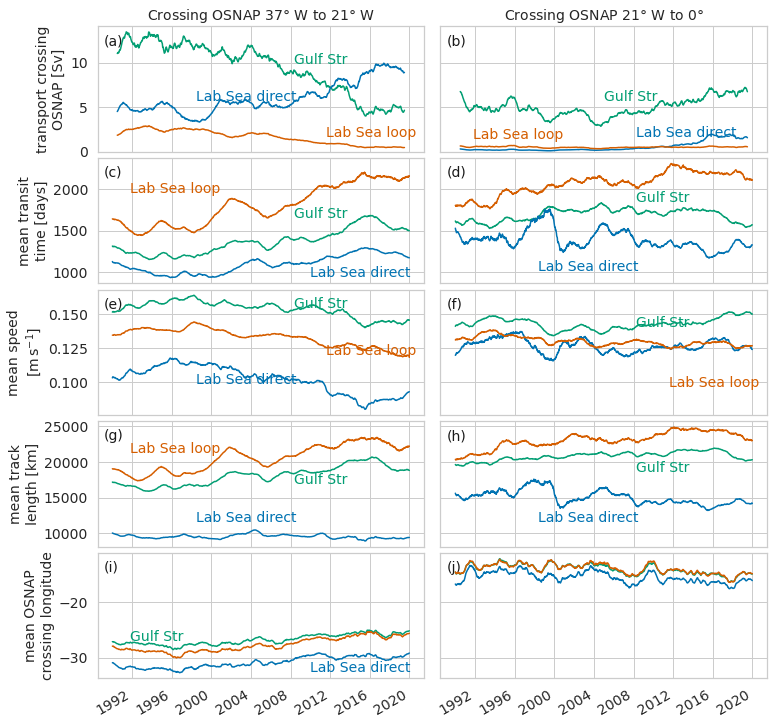

In [41]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 12),sharex='col',sharey='row',gridspec_kw={'hspace':0.05,'wspace':0.05})


ax = axes[0,0]
(ngs_w_5day.rolling(time=73,center=True).mean()*0.01797).plot(ax=ax,color='C2',zorder=8)
(nld_w_5day.rolling(time=73,center=True).mean()*0.01797).plot(ax=ax,color='C0',zorder=9)
(nll_w_5day.rolling(time=73,center=True).mean()*0.01797).plot(ax=ax,color='C3',zorder=9)
ax.set_ylabel('transport crossing\nOSNAP [Sv]')
ax.set_xlabel('')
ax.set_ylim(bottom=0)
ax.text(0.02,0.85,'(a)',transform=ax.transAxes, color='k')
ax.text(0.6,0.7,'Gulf Str',transform=ax.transAxes, color='C2')
ax.text(0.7,0.12,'Lab Sea loop',transform=ax.transAxes, color='C3')
ax.text(0.3,0.4,'Lab Sea direct',transform=ax.transAxes, color='C0')
ax.set_title('Crossing OSNAP $37\degree$ W to $21\degree$ W')

ax = axes[1,0]
(deltaT_w_5day_gs/(1.0e9*24*3600)).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C2',zorder=8)
(deltaT_w_5day_ld/(1.0e9*24*3600)).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C0',zorder=9)
(deltaT_w_5day_ll/(1.0e9*24*3600)).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C3',zorder=9)
ax.set_ylabel('mean transit\ntime [days]')
ax.set_xlabel('')
ax.text(0.02,0.85,'(c)',transform=ax.transAxes, color='k')
ax.text(0.6,0.52,'Gulf Str',transform=ax.transAxes, color='C2')
ax.text(0.1,0.72,'Lab Sea loop',transform=ax.transAxes, color='C3')
ax.text(0.65,0.05,'Lab Sea direct',transform=ax.transAxes, color='C0')

ax = axes[2,0]
(dist_w_5day_gs/(deltaT_w_5day_gs.astype(int)/1.0e09)).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C2',zorder=8)
(dist_w_5day_ld/(deltaT_w_5day_ld.astype(int)/1.0e09)).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C0',zorder=9)
(dist_w_5day_ll/(deltaT_w_5day_ll.astype(int)/1.0e09)).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C3',zorder=9)
ax.set_ylabel('mean speed\n[$\mathrm{m\, s^{-1}}$]')
ax.set_xlabel('')
ax.text(0.02,0.85,'(e)',transform=ax.transAxes, color='k')
ax.text(0.6,0.85,'Gulf Str',transform=ax.transAxes, color='C2')
ax.text(0.7,0.48,'Lab Sea loop',transform=ax.transAxes, color='C3')
ax.text(0.3,0.25,'Lab Sea direct',transform=ax.transAxes, color='C0')

ax = axes[3,0]
(dist_w_5day_gs/1000).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C2',zorder=8)
(dist_w_5day_ld/1000).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C0',zorder=9)
(dist_w_5day_ll/1000).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C3',zorder=9)
ax.set_ylabel('mean track\nlength [km]')
ax.set_xlabel('')
ax.text(0.02,0.85,'(g)',transform=ax.transAxes, color='k')
ax.text(0.6,0.5,'Gulf Str',transform=ax.transAxes, color='C2')
ax.text(0.1,0.75,'Lab Sea loop',transform=ax.transAxes, color='C3')
ax.text(0.3,0.2,'Lab Sea direct',transform=ax.transAxes, color='C0')

ax = axes[4,0]
(lon_w_5day_gs).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C2',zorder=8)
(lon_w_5day_ld).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C0',zorder=9)
(lon_w_5day_ll).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C3',zorder=9)
ax.set_ylabel('mean OSNAP\ncrossing longitude')
ax.set_xlabel('')
ax.text(0.02,0.85,'(i)',transform=ax.transAxes, color='k')
ax.text(0.1,0.3,'Gulf Str',transform=ax.transAxes, color='C2')
ax.text(0.65,0.05,'Lab Sea direct',transform=ax.transAxes, color='C0')


ax = axes[0,1]
(ngs_e_5day.rolling(time=73,center=True).mean()*0.01797).plot(ax=ax,color='C2',zorder=8)
(nld_e_5day.rolling(time=73,center=True).mean()*0.01797).plot(ax=ax,color='C0',zorder=9)
(nll_e_5day.rolling(time=73,center=True).mean()*0.01797).plot(ax=ax,color='C3',zorder=9)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(bottom=0)
ax.text(0.02,0.85,'(b)',transform=ax.transAxes, color='k')
ax.text(0.5,0.4,'Gulf Str',transform=ax.transAxes, color='C2')
ax.text(0.6,0.12,'Lab Sea direct',transform=ax.transAxes, color='C0')
ax.text(0.1,0.10,'Lab Sea loop',transform=ax.transAxes, color='C3')
ax.set_title('Crossing OSNAP $21\degree$ W to $0\degree$')

ax = axes[1,1]
(deltaT_e_5day_gs/(1.0e9*24*3600)).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C2',zorder=8)
(deltaT_e_5day_ld/(1.0e9*24*3600)).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C0',zorder=9)
(deltaT_e_5day_ll/(1.0e9*24*3600)).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C3',zorder=9)
ax.set_ylabel('')
ax.set_xlabel('')
ax.text(0.02,0.85,'(d)',transform=ax.transAxes, color='k')
ax.text(0.6,0.65,'Gulf Str',transform=ax.transAxes, color='C2')
ax.text(0.3,0.1,'Lab Sea direct',transform=ax.transAxes, color='C0')

ax = axes[2,1]
(dist_e_5day_gs/(deltaT_e_5day_gs.astype(int)/1.0e09)).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C2',zorder=8)
(dist_e_5day_ld/(deltaT_e_5day_ld.astype(int)/1.0e09)).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C0',zorder=9)
(dist_e_5day_ll/(deltaT_e_5day_ll.astype(int)/1.0e09)).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C3',zorder=9)
ax.set_ylabel('')
ax.set_xlabel('')
ax.text(0.02,0.85,'(f)',transform=ax.transAxes, color='k')
ax.text(0.6,0.7,'Gulf Str',transform=ax.transAxes, color='C2')
ax.text(0.7,0.22,'Lab Sea loop',transform=ax.transAxes, color='C3')

ax = axes[3,1]
(dist_e_5day_gs/1000).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C2',zorder=8)
(dist_e_5day_ld/1000).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C0',zorder=9)
(dist_e_5day_ll/1000).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C3',zorder=9)
ax.set_ylabel('')
ax.set_xlabel('')
ax.text(0.02,0.85,'(h)',transform=ax.transAxes, color='k')
ax.text(0.6,0.6,'Gulf Str',transform=ax.transAxes, color='C2')
ax.text(0.3,0.2,'Lab Sea direct',transform=ax.transAxes, color='C0')

ax = axes[4,1]
(lon_e_5day_gs).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C2',zorder=8)
(lon_e_5day_ld).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C0',zorder=9)
(lon_e_5day_ll).rolling(time=73,center=True,min_periods=37).mean().plot(ax=ax,color='C3',zorder=9)
ax.set_ylabel('')
ax.set_xlabel('')
ax.text(0.02,0.85,'(j)',transform=ax.transAxes, color='k')


plt.savefig(project_path / figure_path / 'transit_dist_time_speed_lon_w_e.png',dpi=300, bbox_inches='tight')



In [42]:
ds

<xarray.Dataset>
Dimensions:           (ends: 2, traj: 3513397)
Coordinates:
    dim_0             (traj) int64 6 6 6 6 6 6 6 6 6 ... 12 12 12 12 12 12 12 12
Dimensions without coordinates: ends, traj
Data variables: (12/37)
    lat               (ends, traj) float32 59.15 59.01 59.04 ... 44.11 36.19
    lon               (ends, traj) float32 -33.92 -32.55 ... -13.87 -14.91
    mxl               (ends, traj) float32 214.9 338.1 337.1 ... 122.3 78.34
    salt              (ends, traj) float32 34.93 35.12 35.1 ... 35.61 35.64
    temp              (ends, traj) float32 3.812 7.324 6.744 ... 14.07 12.66
    time              (ends, traj) datetime64[ns] 1990-01-03T12:00:00 ... 200...
    ...                ...
    depth_transport   (ends, traj) float64 1.068 0.3546 0.801 ... 0.1644 0.5197
    lon_transport     (ends, traj) float64 -0.06097 -0.0585 ... -0.02493 -0.0268
    tempxvol          (ends, traj) float64 0.0804 0.2458 ... 0.1951 0.1954
    saltxvol          (ends, traj) float64 0.7368 1.179 2.112 ... 0.4936 0.5501
    depthxvol         (ends, traj) float64 12.53 6.62 26.81 ... 1.268 4.464
    lonxvol           (ends, traj) float64 -0.7156 -1.092 ... -0.1923 -0.2301
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

In [51]:
ds1 = ds.where(ds.LabCu_is_source).isel(ends=1)
ds2 = ds.where(ds.LabCu_is_source).isel(traj=slice(0,1240000,1),ends=1)
ds3 = ds.where(ds.LabCu_is_source).isel(traj=slice(1240000,None,1),ends=1)


sigbins = np.arange(10.0,28.0001, 0.01)
sigbins_upper = np.arange(10.01,28.0001, 0.01)

trsp_sigma = histogram((ds1.rho0-1000.0), bins=[sigbins], dim=["traj"], weights=ds1.vol_trans_normal)
trsp_sigma2 = histogram((ds2.rho0-1000.0), bins=[sigbins], dim=["traj"], weights=ds2.vol_trans_normal)
trsp_sigma3 = histogram((ds3.rho0-1000.0), bins=[sigbins], dim=["traj"], weights=ds3.vol_trans_normal)
# trsp_sigma.vosigma0_bin.data = sigbins_upper
# trsp_sigma.attrs["long_name"]='MOC'
# trsp_sigma.vosigma0_bin.attrs["long_name"]= r'$\sigma_{\theta}$'
# trsp_sigma.time_counter.attrs["long_name"]= "Date"
# trsp_sigma.vosigma0_bin.attrs["units"]= r'$\mathrm{kg\ m^{-3}}$'
# trsp_sigma.attrs["units"]='Sv'


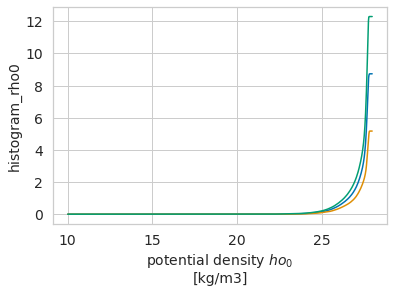

In [52]:
(trsp_sigma.cumsum()*10.0/(73.0*30.0)).plot()
(trsp_sigma2.cumsum()*10.0/(73.0*15.0)).plot()
(trsp_sigma3.cumsum()*10.0/(73.0*15.0)).plot()


In [53]:
path_home = Path('~')

path_data_output = path_home / 'transports' / 'data_output' / 'watermassBudget' / 'boundaryFluxes'


amoc_osnap_lss = xr.open_dataarray(path_data_output / 'boundary_flux_osnap_lss_sigma_in.nc')

(27.4, 28.1)

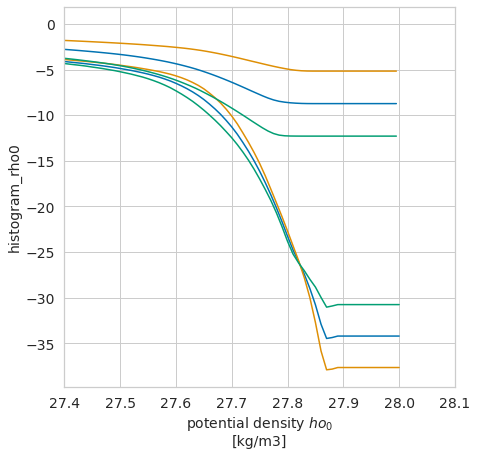

In [63]:
fig,ax = plt.subplots(figsize = (7,7))

amoc_osnap_lss.mean(dim='time_counter').cumsum().plot(ax=ax)
amoc_osnap_lss.isel(time_counter=slice(0,180,1)).mean(dim='time_counter').cumsum().plot(ax=ax)
amoc_osnap_lss.isel(time_counter=slice(180,None,1)).mean(dim='time_counter').cumsum().plot(ax=ax)
(-trsp_sigma.cumsum()*10.0/(73.0*30.0)).plot(ax=ax,color='C0')
(-trsp_sigma2.cumsum()*10.0/(73.0*15.0)).plot(ax=ax,color='C1')
(-trsp_sigma3.cumsum()*10.0/(73.0*15.0)).plot(ax=ax,color='C2')
ax.set_xlim(left=27.4,right=28.1)


(27.4, 28.1)

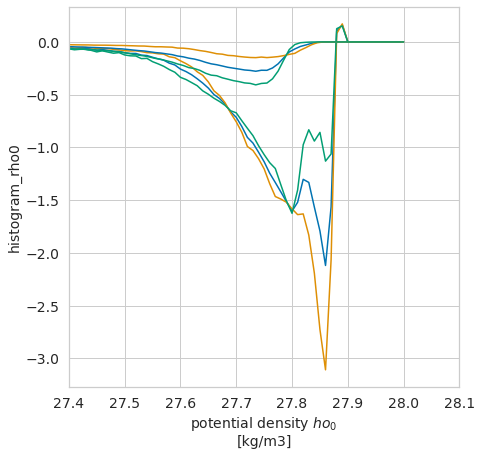

In [65]:
fig,ax = plt.subplots(figsize = (7,7))

amoc_osnap_lss.mean(dim='time_counter').plot(ax=ax)
amoc_osnap_lss.isel(time_counter=slice(0,180,1)).mean(dim='time_counter').plot(ax=ax)
amoc_osnap_lss.isel(time_counter=slice(180,None,1)).mean(dim='time_counter').plot(ax=ax)
(-trsp_sigma*10.0/(73.0*30.0)).plot(ax=ax,color='C0')
(-trsp_sigma2*10.0/(73.0*15.0)).plot(ax=ax,color='C1')
(-trsp_sigma3*10.0/(73.0*15.0)).plot(ax=ax,color='C2')
ax.set_xlim(left=27.4,right=28.1)


In [48]:
np.datetime64('2010-01-01') > np.datetime64('2010-02-01')

False